In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder    
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("cleaned_data_with_region_and_price_per_m2.csv")
print(display(df.head()))

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <F2F42313-BF4F-3B95-A853-AE1DE94D4C87> /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


## Preprocessing
1. First drop irrelevant features.
2. Since dropped the columns for Terrace and Garden area, do not need to impute missing values.
3. Ordinal encode 'Building condition'
3. Turn categorical features into binary/numeric ('house'/'apartment', 'province') - onehot encoder

In [175]:
# Transforming qualitative into numerical. Encoded building condition ranges from 0 - 5:
# ['As new' 'Good' 'To be done up' 'Just renovated' 'To renovate' 'To restore']

# Assuming 'df' is your DataFrame and has a column named 'Building condition'
# Select the 'Building condition' column
def encode_building_condition(df):    
    '''
    Encodes building condition with OrdinalEncoder, giving hierarcy ranging from 0 - 5:
    ['As new' 'Good' 'To be done up' 'Just renovated' 'To renovate' 'To restore']
    This function also drops the column originally titled 'Building Condition'.
    Parameters:
    df (DataFrame): The original or modified DataFrame
    '''
    building_condition_column = df[['Building condition']]
    # Define and fit the OrdinalEncoder
    encoder = OrdinalEncoder()
    encoded_building_condition = encoder.fit_transform(building_condition_column)
    # Add the transformed data back to the DataFrame
    df['Encoded Building Condition'] = encoded_building_condition.ravel()
    df = df.drop(['Building condition'], axis=1)
    # Display the updated DataFrame
    print(display(df.head(50)))
    return df

df = encode_building_condition(df)

,Unnamed: 0,Property ID,Locality data,Price,Property type,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Open fire,Terrace surface m²,Garden area m²,Swimming pool,Price per m²,Region,Province,Encoded Building Condition
0,9333,20135745,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,8474.567797,Flanders,West Flanders,0.0
1,1737,20206578,4140,999999,house,13.0,778.0,1,0,1,443.0,NaN,0,1285.345758,Wallonia,Liège,1.0
2,7967,20135600,8300,999999,apartment,2.0,118.0,0,0,1,NaN,NaN,0,8474.567797,Flanders,West Flanders,0.0
3,2563,20234889,1851,999000,house,4.0,345.0,1,1,1,15.0,NaN,0,2895.652174,Flanders,Flemish Brabant,1.0
4,5435,20215434,1160,997000,apartment,3.0,144.0,0,0,1,43.0,NaN,0,6923.611111,Brussels,Brussels,0.0
5,1004,20226523,8420,995000,house,4.0,568.0,0,0,1,NaN,NaN,0,1751.760563,Flanders,West Flanders,1.0
6,2136,20207321,1150,995000,house,5.0,339.0,0,0,1,NaN,NaN,0,2935.103245,Brussels,Brussels,0.0
7,6077,20238340,1040,995000,apartment,3.0,220.0,0,0,1,25.0,NaN,0,4522.727273,Brussels,Brussels,0.0
8,2747,20161968,2000,995000,house,5.0,398.0,1,0,1,13.0,78.0,0,2500.000000,Flanders,Antwerp,1.0
9,8480,10626636,8301,995000,apartment,3.0,100.0,0,0,1,NaN,NaN,0,9950.000000,Flanders,West Flanders,0.0


None


In [176]:
# Drop unnecessary columns not needed for the model
df = df.drop(['Property ID', 'Open fire', 'Unnamed: 0', 'Locality data', 'Region', 'Price per m²', 'Terrace surface m²', 'Garden area m²'], axis=1)
display(df.head(10))

,Price,Property type,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Province,Encoded Building Condition
0,999999,apartment,2.0,118.0,0,0,0,West Flanders,0.0
1,999999,house,13.0,778.0,1,0,0,Liège,1.0
2,999999,apartment,2.0,118.0,0,0,0,West Flanders,0.0
3,999000,house,4.0,345.0,1,1,0,Flemish Brabant,1.0
4,997000,apartment,3.0,144.0,0,0,0,Brussels,0.0
5,995000,house,4.0,568.0,0,0,0,West Flanders,1.0
6,995000,house,5.0,339.0,0,0,0,Brussels,0.0
7,995000,apartment,3.0,220.0,0,0,0,Brussels,0.0
8,995000,house,5.0,398.0,1,0,0,Antwerp,1.0
9,995000,apartment,3.0,100.0,0,0,0,West Flanders,0.0


#### OneHotEncoder

In [177]:
def one_hot_encode_columns(df, columns_to_encode):
    """
    One-hot encode the specified columns in the DataFrame.
    Parameters:
    df (DataFrame): The original DataFrame
    columns_to_encode (list): List of columns to be one-hot encoded
    Returns:
    DataFrame: The DataFrame with the specified columns one-hot encoded and added.
    """
    for column in columns_to_encode:   
        column_data = df[[column]]
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_data = encoder.fit_transform(column_data) # fit_transform applies the encoder
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
        df = df.drop(column, axis=1)
    return df # return outside the loop to process all columns before returning updated DataFrame
    
columns_to_encode = ['Property type', 'Province']
df = one_hot_encode_columns(df, columns_to_encode) # update the df on each iteration

df.head(50)


,Price,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,999999,2.0,118.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,999999,13.0,778.0,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,999999,2.0,118.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,999000,4.0,345.0,1,1,0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997000,3.0,144.0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,995000,4.0,568.0,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,995000,5.0,339.0,0,0,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,995000,3.0,220.0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,995000,5.0,398.0,1,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,995000,3.0,100.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [178]:
modified_df = df.drop(['Swimming pool', 'Furnished'], axis=1)
print(display(modified_df.head(5)))

,Price,Number of bedrooms,Living area m²,Equipped kitchen,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,999999,2.0,118.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,999999,13.0,778.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,999999,2.0,118.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,999000,4.0,345.0,1,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,997000,3.0,144.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None


### Spilt data set

Split your data into train and test.

random_state=41 ensures reproducibility. Will produce the same output, doesnt change the different test and train columns each time you rerun the code

test_size=0.2 means 20% of the data will be used for testing and the other 80% will be used for training.

In [179]:
def split_dataset(df):
    y = df['Price'] # Target variable
    X = df.drop(columns=['Price']) # All other column features in df after dropping the target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=41, test_size=0.2) # Get 4 parameters back
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

# Call the function and assign the returned values to variables
X_train, X_test, y_train, y_test = split_dataset(df)

split_dataset(df)

X_train shape: (6684, 17)
X_test shape: (1672, 17)
X_train shape: (6684, 17)
X_test shape: (1672, 17)


(      Number of bedrooms  Living area m²  Equipped kitchen  Furnished  \
 2542                 5.0           205.0                 0          0   
 4191                 3.0           110.0                 0          0   
 4839                 2.0           106.0                 1          0   
 1587                 6.0           379.0                 0          0   
 3968                 4.0           165.0                 0          0   
 ...                  ...             ...               ...        ...   
 4339                 3.0           154.0                 1          0   
 5200                 2.0            79.0                 0          0   
 4066                 3.0            96.0                 0          0   
 931                  2.0           115.0                 0          0   
 1984                 4.0           281.0                 0          0   
 
       Swimming pool  Encoded Building Condition  Property type_house  \
 2542              0                 

In [180]:
split_dataset(modified_df)

X_train shape: (6684, 15)
X_test shape: (1672, 15)


(      Number of bedrooms  Living area m²  Equipped kitchen  \
 2542                 5.0           205.0                 0   
 4191                 3.0           110.0                 0   
 4839                 2.0           106.0                 1   
 1587                 6.0           379.0                 0   
 3968                 4.0           165.0                 0   
 ...                  ...             ...               ...   
 4339                 3.0           154.0                 1   
 5200                 2.0            79.0                 0   
 4066                 3.0            96.0                 0   
 931                  2.0           115.0                 0   
 1984                 4.0           281.0                 0   
 
       Encoded Building Condition  Property type_house  Province_Brussels  \
 2542                         0.0                  1.0                0.0   
 4191                         0.0                  1.0                0.0   
 4839      

In [181]:
# Ensure no missing values are present
print(df.isnull().sum())


Price                         0
Number of bedrooms            0
Living area m²                0
Equipped kitchen              0
Furnished                     0
Swimming pool                 0
Encoded Building Condition    0
Property type_house           0
Province_Brussels             0
Province_East Flanders        0
Province_Flemish Brabant      0
Province_Hainaut              0
Province_Limburg              0
Province_Liège                0
Province_Luxembourg           0
Province_Namur                0
Province_Walloon Brabant      0
Province_West Flanders        0
dtype: int64



### Standardize dataset features
Use numpy's mean and standard deviation functions to standardize each feature of the training and testing set. These are `np.mean()` and `np.std()`.

Standardizing is important in models like linear regression, logistic regression, SVM, k-nearest neighbors (KNN), and neural networks as they are sensitive to the scale of the input features. Scale means the range and distribution of values for different features (columns) in your dataset. e.g. Size in sq meters could range from 20-500, while number of rooms might range from 1 to 10.

One reason to use mean and stdev from trained dataset is the test set is meant to represent unseen data. By applying the mean and standard deviation from the training set, you are simulating how the model will perform in a real-world situation, where new data will be standardized based on the parameters of the data the model was trained on.

fit_transform(X_train): Calculates the mean and standard deviation from the training data and applies the transformation to standardize X_train.




In [182]:
def standardize_data_features(df):    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = split_dataset(df)
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test) # Uses same mean and standard deviation calculated from the training set to transform the test data
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=X_train.columns)
    X_test_standardized = pd.DataFrame(X_test_standardized, columns=X_test.columns)
    
    print(display(X_train_standardized.head()))
    print(display(X_test_standardized.head()))
    # Check mean and standard deviation of the training data after scaling
    print("Means of standardized features (training set):", X_train_standardized.mean(axis=0).values)
    print("Standard deviations of standardized features (training set):", X_train_standardized.std(axis=0).values)
    return X_train_standardized, X_test_standardized

standardize_data_features(df)

X_train shape: (6684, 17)
X_test shape: (1672, 17)


,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,1.751085,0.600095,-0.801915,-0.20118,-0.132896,-1.084831,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
1,0.154869,-0.424523,-0.801915,-0.20118,-0.132896,-1.084831,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,2.269148
2,-0.643239,-0.467665,1.247015,-0.20118,-0.132896,-0.306742,-1.022699,2.062697,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
3,2.549193,2.476762,-0.801915,-0.20118,-0.132896,2.027525,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
4,0.952977,0.168677,-0.801915,-0.20118,-0.132896,-0.306742,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694


None


,Number of bedrooms,Living area m²,Equipped kitchen,Furnished,Swimming pool,Encoded Building Condition,Property type_house,Province_Brussels,Province_East Flanders,Province_Flemish Brabant,Province_Hainaut,Province_Limburg,Province_Liège,Province_Luxembourg,Province_Namur,Province_Walloon Brabant,Province_West Flanders
0,0.154869,0.546167,-0.801915,-0.20118,-0.132896,2.805615,0.977805,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,2.976308,-0.195887,-0.155598,-0.192987,-0.440694
1,-0.643239,-0.715730,-0.801915,-0.20118,-0.132896,-1.084831,-1.022699,-0.484802,-0.518917,3.535962,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
2,-0.643239,-0.769657,1.247015,-0.20118,-0.132896,1.249436,-1.022699,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
3,0.154869,0.006895,1.247015,-0.20118,-0.132896,-0.306742,0.977805,-0.484802,1.927091,-0.282808,-0.193404,-0.100625,-0.335987,-0.195887,-0.155598,-0.192987,-0.440694
4,0.154869,-0.208814,-0.801915,-0.20118,-0.132896,2.805615,-1.022699,-0.484802,-0.518917,-0.282808,-0.193404,-0.100625,2.976308,-0.195887,-0.155598,-0.192987,-0.440694


None
Means of standardized features (training set): [ 1.32881272e-17 -1.47763974e-16  5.42155588e-17  1.43511773e-17
  1.80718529e-17  4.57111574e-17  7.83999503e-17 -1.06305017e-17
  8.50440139e-18  1.91349031e-17  1.59457526e-18 -2.97654048e-17
  7.01613114e-17  3.50806557e-17 -1.62115151e-17  2.12610035e-18
  3.72067561e-17]
Standard deviations of standardized features (training set): [1.00007481 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481
 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481
 1.00007481 1.00007481 1.00007481 1.00007481 1.00007481]


(      Number of bedrooms  Living area m²  Equipped kitchen  Furnished  \
 0               1.751085        0.600095         -0.801915   -0.20118   
 1               0.154869       -0.424523         -0.801915   -0.20118   
 2              -0.643239       -0.467665          1.247015   -0.20118   
 3               2.549193        2.476762         -0.801915   -0.20118   
 4               0.952977        0.168677         -0.801915   -0.20118   
 ...                  ...             ...               ...        ...   
 6679            0.154869        0.050037          1.247015   -0.20118   
 6680           -0.643239       -0.758872         -0.801915   -0.20118   
 6681            0.154869       -0.575519         -0.801915   -0.20118   
 6682           -0.643239       -0.370596         -0.801915   -0.20118   
 6683            0.952977        1.419788         -0.801915   -0.20118   
 
       Swimming pool  Encoded Building Condition  Property type_house  \
 0         -0.132896                 

### Load and fit the Linear Regression model

1. Import `LinearRegression` from `sklearn`
2. Create a `regressor` variable and instantiate your `LinearRegression` class.
3. Train your model with `X_train` and `y_train`.
4. Display the score of your model with `X_train` and `y_train`.
5. Use the predict method of your model on your test dataset (`X_test`).
6. Display the score of your model with `X_test` and `y_test`.

R2=1: This means that the model perfectly predicts the target variable. The predictions match the actual values exactly.

R2=0: This means the model does not explain any of the variance in the target variable. It performs as poorly as simply predicting the mean of the target.

Negative R2: This indicates that the model is worse than simply predicting the mean for every observation (which can happen if the model does not fit the data well).

In [183]:
lr = LinearRegression()
# Finds the best fit line on the training model (find m (slope) and c (coefficient, y-intercept)) on training parameters
lr.fit(X_train, y_train) 
c = lr.intercept_ # View the fitted and calculated y-intercept
m = lr.coef_ # View the fitted and calculated slope value
print(m, c)

[  34469.16656875     840.6539433   -19388.71907454   42662.62118892
  104206.37801289  -37636.83394546  -17286.233641     59656.938096
  -19229.94544241   43184.69038748 -129231.81143011  -30572.80270289
 -114992.77121644  -91185.93290892 -120982.75620389   28308.69357438
   28223.61482678] 227251.1197442554


In [184]:
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f"Coefficient of determination (R^2) for trained data: {train_score}")
print(f"Coefficient of determination (R^2) for test data: {test_score}")
y_pred = lr.predict(X_test) # Generate predictions from a fitted liner regression model on new unseen data.
print(y_test)
print(y_pred)
lr.score(X_test, y_test)

# Calculate Mean Squared Error and R^2 Score from sklearn.metrics import
mse = mean_squared_error(y_test, y_pred)
root_mse = np.sqrt(mse)
print(f"Root Mean Squared Error: {root_mse}")
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficient of determination (R^2) for trained data: 0.4553198454259427
Coefficient of determination (R^2) for test data: 0.47414283593214024
6526    229000
4330    325000
4739    299900
4151    335000
7497    180000
         ...  
7732    169000
852     649000
3257    385000
141     910000
2511    429000
Name: Price, Length: 1672, dtype: int64
[178326.23352601 409148.42056323 229461.23954833 ... 507408.02342497
 487051.03091175 493108.65882697]
Root Mean Squared Error: 139468.32634044572
Mean Squared Error: 19451414052.20507
R^2 Score: 0.47414283593214024


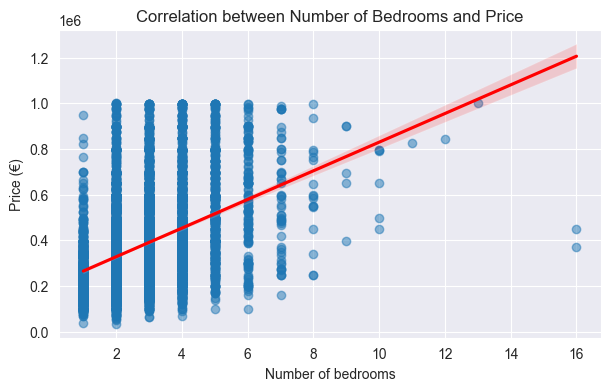

In [185]:
# Scatter plot of 'Number of Bedrooms' vs 'Price'

plt.figure(figsize=(7, 4))
sns.regplot(x='Number of bedrooms', y='Price', data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel('Number of bedrooms')
plt.ylabel('Price (€)')
plt.title('Correlation between Number of Bedrooms and Price')

plt.show()


### Random Forest Regression model

In [186]:
regressor_forest = RandomForestRegressor(n_estimators=200, random_state=0)
regressor_forest.fit(X_train, y_train)
regressor_forest.score(X_test, y_test)

0.5632282091346761

In [187]:
param_grid = {'n_estimators': [30, 50, 100],
              'max_features': [8, 12, 20],
              'max_depth':[None, 4, 8]
              }

grid_search = GridSearchCV(estimator=regressor_forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, random_state=0),
             param_grid={'max_depth': [None, 4, 8], 'max_features': [8, 12, 20],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [188]:
best_forest = grid_search.best_estimator_
best_forest.score(X_test, y_test)

0.5634935101364957

In [189]:
correlation_matrix = df.corr(method='pearson')
price_correlation = correlation_matrix['Price'].sort_values(ascending=False)
print(price_correlation)

Price                         1.000000
Living area m²                0.504011
Number of bedrooms            0.411326
Swimming pool                 0.145018
Property type_house           0.126417
Province_Brussels             0.122358
Province_Flemish Brabant      0.118203
Province_Walloon Brabant      0.047548
Province_West Flanders        0.047099
Furnished                     0.026321
Province_Limburg              0.021255
Province_East Flanders       -0.005797
Province_Luxembourg          -0.069981
Equipped kitchen             -0.072636
Province_Namur               -0.086678
Province_Hainaut             -0.109880
Province_Liège               -0.198728
Encoded Building Condition   -0.223469
Name: Price, dtype: float64


### XGBoost Regressor

In [192]:
# Initialize and Train the XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)


NameError: name 'xgb' is not defined